In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import re
from collections import Counter, defaultdict

In [3]:
french_texts = [
    "Je suis étudiant à l'université de Paris.",
    "J'aime beaucoup la cuisine française.",
    "Le chat mange la souris dans le jardin.",
    "Nous allons au cinéma ce soir avec nos amis.",
    "Il fait très beau aujourd'hui en France.",
    "Elle lit un livre très intéressant.",
    "Bonjour comment allez-vous aujourd'hui?",
    "La France est un pays magnifique.",
    "J'apprends le français depuis deux ans.",
    "Nous mangeons des croissants au petit-déjeuner.",
    "Il pleut beaucoup en automne.",
    "Elle travaille dans une grande entreprise.",
    "Les étudiants étudient à la bibliothèque.",
    "Mon père aime jouer au football.",
    "Ma mère cuisine très bien.",
    "Nous habitons dans une belle maison.",
    "Les enfants jouent dans le parc.",
    "Il faut apprendre les langues étrangères.",
    "Elle parle couramment trois langues différentes.",
    "Nous voyageons souvent en Europe."
]

class FrenchTextPreprocessor:
  def __init__(self):
    self.tokenizer = None

  def clean_text(self, text):
    """Clean and normalize French text"""
    text = text.lower()

    # Keep French accents and basic punctuation
    text = re.sub(r'[^\w\s\àâäéèêëïîôöùûüÿç\.\!\?]', '', text)

    text = "<START> " + text + " <END>"
    return text

  def preprocess_texts(self, texts):
    """Preprocess list of texts"""
    return [self.clean_text(text) for text in texts]

preprocessor = FrenchTextPreprocessor()
cleaned_texts = preprocessor.preprocess_texts(french_texts)

print("Original text:", french_texts[0])
print("Cleaned text:", cleaned_texts[0])

Original text: Je suis étudiant à l'université de Paris.
Cleaned text: <START> je suis étudiant à luniversité de paris. <END>


In [5]:
def create_sequences(texts, sequence_length=4):
  """Create input-output sequences for training"""
  sequences = []

  for text in texts:
    words = text.split()

    # Create sliding window sequences
    for i in range(len(words) - sequence_length):
      # Input: sequence_length words
      # Output: next word
      input_seq = words[i:i + sequence_length]
      target_word = words[i + sequence_length]
      sequences.append((input_seq, target_word))

  return sequences

SEQUENCE_LENGTH = 3
sequences = create_sequences(cleaned_texts, SEQUENCE_LENGTH)

print(f"Total sequences created: {len(sequences)}")
print("First 5 sequences:")
for i in range(5):
  input_seq, target = sequences[i]
  print(f"Input: {' '. join(input_seq)} -> Target: {target}")

Total sequences created: 101
First 5 sequences:
Input: <START> je suis -> Target: étudiant
Input: je suis étudiant -> Target: à
Input: suis étudiant à -> Target: luniversité
Input: étudiant à luniversité -> Target: de
Input: à luniversité de -> Target: paris.


In [6]:
class SimpleNGramModel:
  def __init__(self, n=3):
    self.n = n
    self.ngram_counts = defaultdict(Counter)
    self.vocab = set()

  def train(self, sequences):
    """Train the n-gram model"""
    for input_seq, target in sequences:
      # Create n-gram key
      ngram_key = tuple(input_seq)

      # Count occurrences
      self.ngram_counts[ngram_key][target] += 1

      # Build vocabulary
      self.vocab.update(input_seq)
      self.vocab.add(target)

  def predict(self, input_sequence, top_k=3):
    """Predict next word given input sequence"""
    ngram_key = tuple(input_sequence)

    if ngram_key in self.ngram_counts:
      # Get most common next words
      predictions = self.ngram_counts[ngram_key].most_common(top_k)
      return predictions
    else:
      return [("unknown", 0)]

  def predict_proba(self, input_sequence, word):
    """Get probability of specific word"""
    ngram_key = tuple(input_sequence)

    if ngram_key in self.ngram_counts:
      total_count = sum(self.ngram_counts[ngram_key].values())
      word_count = self.ngram_counts[ngram_key][word]
      return word_count / total_count if total_count > 0 else 0
    return 0

ngram_model = SimpleNGramModel(n=SEQUENCE_LENGTH)
ngram_model.train(sequences)

test_sequence = ["je", "suis", "très"]
predictions = ngram_model.predict(test_sequence, top_k=5)
print(f"\nN-gram predictions for '{' '.join(test_sequence)}':")
for word, count in predictions:
  prob = ngram_model.predict_proba(test_sequence, word)
  print(f"  {word}: {count} occurrences (prob: {prob:.3f})")


N-gram predictions for 'je suis très':
  unknown: 0 occurrences (prob: 0.000)


In [13]:
class FrenchLanguageModel:
  def __init__(self, vocab_size, embedding_dim=50, lstm_units=128):
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.lstm_units = lstm_units
    self.model = None
    self.tokenizer = None

  def build_model(self, sequence_length):
    """Build LSTM model for language modeling"""
    self.model = Sequential([
        Embedding(self.vocab_size, self.embedding_dim,
                  input_length=sequence_length),
        LSTM(self.lstm_units, return_sequences=False, dropout=0.2),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(self.vocab_size, activation="softmax")
    ])

    self.model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return self.model

  def prepare_data(self, sequences, max_vocab_size=1000):
    """Prepare data for neural network training"""
    # Extract input sequences and targets
    input_texts = [' '.join(seq[0]) for seq in sequences]
    targets = [seq[1] for seq in sequences]

    # Create tokenizer
    self.tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<UNK>")

    # Fit on all text (input + targets)
    all_text = input_texts + targets
    self.tokenizer.fit_on_texts(all_text)

    # Convert to sequences
    input_sequences = self.tokenizer.texts_to_sequences(input_texts)
    target_sequences = self.tokenizer.texts_to_sequences(targets)

    # Pad input sequences
    X = pad_sequences(input_sequences, maxlen=SEQUENCE_LENGTH, padding="pre")

    # Convert targets to integers
    y = np.array([seq[0] if seq else 0 for seq in target_sequences])

    return X, y

  def train_model(self, X, y, epochs=50, validation_split=0.2):
    """Train the LSTM model"""
    history = self.model.fit(
        X, y,
        epochs=epochs,
        batch_size=32,
        validation_split=validation_split,
        verbose=1
    )
    return history

  def predict_next_word(self, input_text, top_k=5):
    """Predict next word given input text"""
    # Tokenize input
    input_seq = self.tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=SEQUENCE_LENGTH, padding="pre")

    # Get predictions
    predictions = self.model.predict(input_seq, verbose=0)[0]

    # Get top k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]

    results = []
    for idx in top_indices:
      if idx < len(self.tokenizer.index_word):
        word = self.tokenizer.index_word.get(idx, "<UNK>")
        probability = predictions[idx]
        results.append((word, probability))

    return results

language_model = FrenchLanguageModel(vocab_size=1000)
X, y = language_model.prepare_data(sequences)

print(f"Input shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Vocabulary size: {len(language_model.tokenizer.word_index)}")

model = language_model.build_model(SEQUENCE_LENGTH)
print("\nModel architecture:")
model.summary()

Input shape: (101, 3)
Target shape: (101,)
Vocabulary size: 92

Model architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training the neural network...
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.0000e+00 - loss: 6.9074 - val_accuracy: 0.0000e+00 - val_loss: 6.9060
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.0359 - loss: 6.9014 - val_accuracy: 0.0476 - val_loss: 6.9035
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.0586 - loss: 6.8946 - val_accuracy: 0.0952 - val_loss: 6.9006
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1445 - loss: 6.8856 - val_accuracy: 0.0952 - val_loss: 6.8969
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1289 - loss: 6.8742 - val_accuracy: 0.0952 - val_loss: 6.8922
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1430 - loss: 6.8622 - val_accuracy: 0.0952 - val_loss: 6.8858
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1609 - loss: 6.8426 - val_accuracy: 0.0952 - val_loss: 6.8768
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1719 - loss: 6.8152 -

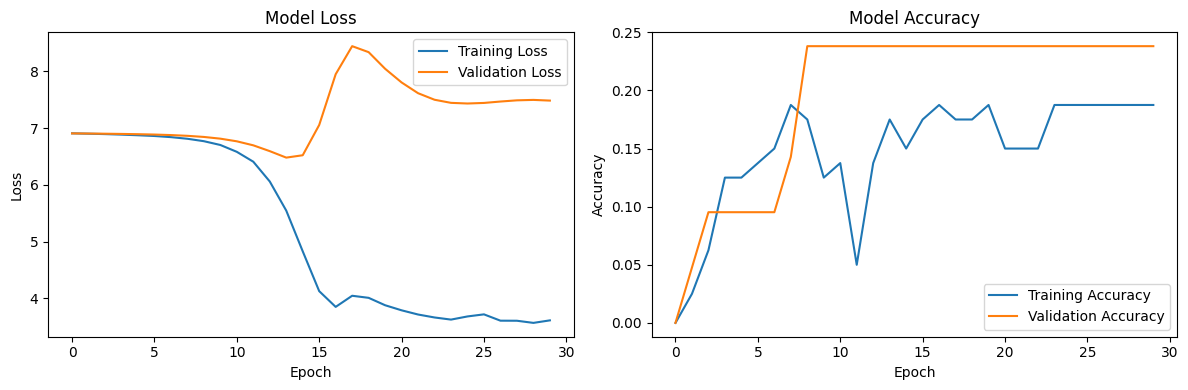

In [14]:
# Train the model
print("\nTraining the neural network...")
history = language_model.train_model(X, y, epochs=30, validation_split=0.2)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()